<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granger Causality**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import numpy as np
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce
import random
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# **Relevance**

In order to determine whether one time series causes another, the most common approach is the so-called **Granger causality test**.

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

# **Analysis**

## **Data Preprocessing**

**Import data**

In [18]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Create Tidy table** (for pivoting)

In [45]:
tidy = pd.melt(data, id_vars=['Date'], value_vars=['Open', 'High', 'Low'],
              var_name='record_type', value_name='price')
# tidy = tidy.set_index('Date')
tidy.head()

,Date,record_type,price
0,2010-02-01,Open,266.301849
1,2010-02-02,Open,266.481171
2,2010-02-03,Open,263.347900
3,2010-02-04,Open,267.497345
4,2010-02-05,Open,263.213409


**Preprocess Original Series**

In [24]:
series = data.drop(columns=['High', 'Low', 'Adj Close', 'Volume'])
series = series.rename(columns={"Date": "date", "Close": "price", "Open" : "open"})
series = series.set_index('date')
series.head()

,open,price
date,,
2010-02-01,266.301849,265.514771
2010-02-02,266.481171,264.568329
2010-02-03,263.347900,269.400208
2010-02-04,267.497345,262.406433
2010-02-05,263.213409,264.653015


**Create Additional Series for Granger Causality Test**

* We are adding a series that is simply a copy of the original series but shifted by t-1. This is a 'ideal case' since in financial time series the previous time step determines to a strong degree the next one.
* Let's also add some gaussian noise with standard deviation and a non-zero mean to the new time series, so that it's not exactly a 1:1 of the original time series

In [0]:
# Define noise
mean = 7 # mean of the distribution to choose from
sigma = 20 # standard deviation of the distribution
sample = series.price.count() # number of elements that are in array

noise = (np.random.normal(mean,sigma,sample))

*Fun fact*: 7 sigma (standard deviations) are chosen from the normal distribution. From the rules for normally distributed data for a daily event this corresponds to a [approximate frequency for daily events](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule#Table_of_numerical_values) every 1.07 billion years (four times in history of Earth).

In [26]:
# Create additional series called 'past'
series = series.rename(columns={"price": "present"})
series['past'] = ((series.present).shift(-1) + noise)
series = series.dropna()
series.head()

,open,present,past
date,,,
2010-02-01,266.301849,265.514771,234.290687
2010-02-02,266.481171,264.568329,279.138765
2010-02-03,263.347900,269.400208,284.744060
2010-02-04,267.497345,262.406433,271.948528
2010-02-05,263.213409,264.653015,268.502370


**Difference both Series for Stationarity in Granger Causality Test**

Granger causality requires stationary time series as input

In [29]:
differenced = series
differenced = differenced.drop(columns=['present', 'past', 'open'])
differenced['present'] = ((series.present) - ((series.present).shift(1)))
differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced['open'] = ((series.open)) - ((series.open).shift(1))
differenced = differenced.dropna()
differenced.head()

,present,past,open
date,,,
2010-02-02,-0.946442,44.848078,0.179322
2010-02-03,4.831879,5.605295,-3.133271
2010-02-04,-6.993775,-12.795531,4.149445
2010-02-05,2.246582,-3.446158,-4.283936
2010-02-08,1.085938,12.681152,2.042359


## **Exploratory Data Analysis**

Since both series originate in the same time series (just one was shifted and enriched with some gaussian noise), we will continue analyzing only the 'present' data time series.

* Is there a seasonality?
* Is there a trend?
* Is there autocorrelation present?
* What is the distribution?
* Are data stationary?

**Trend & Seasonality (Time Series Decomposition)**

The components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

Additive Model
* y(t) = Level + Trend + Seasonality + Noise 1 y(t) = Level + Trend + Seasonality + Noise
* An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

Multiplicative Model
* y(t) = Level Trend Seasonality Noise 1 y(t) = Level Trend Seasonality Noise
* A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time

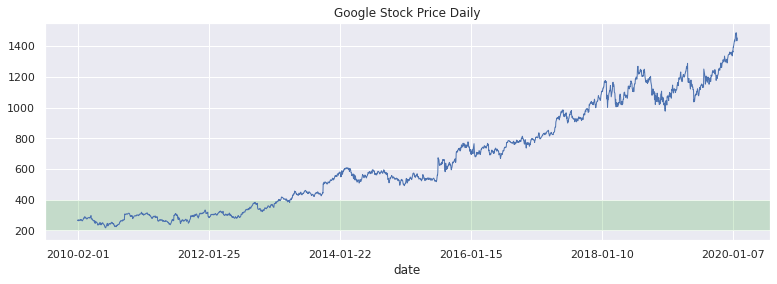

In [51]:
sns.set(rc={'figure.figsize':(13, 4)})
series.present.plot(linewidth=1.0,title='Google Stock Price Daily')
plt.axhspan(200, 400, facecolor='#2ca02c', alpha=0.2)
# plt.axvspan('2010-02-08', '2010-02-12', facecolor='#2ca02c', alpha=0.5)

Reviewing the line plot, it suggests that there may be a linear trend, but it is hard to be sure from eye-balling. There may be no seasonality, and the amplitude (height) of the variance appears to be increasing, suggesting that it is multiplicative.

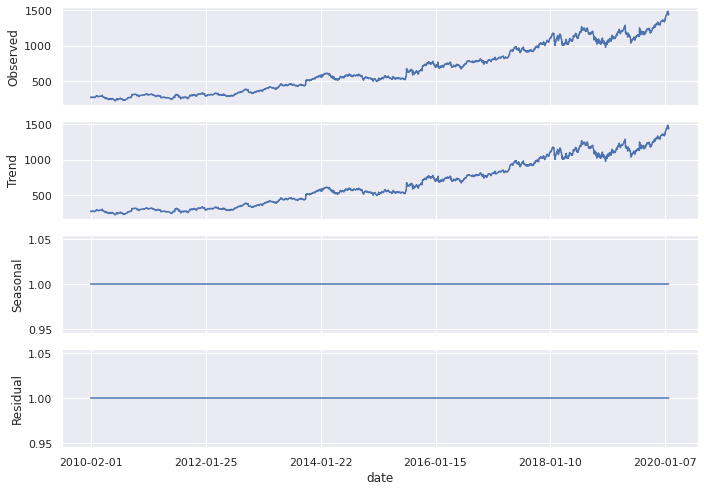

In [43]:
sns.set(rc={'figure.figsize':(10, 7)})
decompose = series.present
result = seasonal_decompose(decompose, model='multiplicative', freq=1) # or additive
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.plot()
pyplot.show()

Looks like the entire series was taken as the trend component and that there was no seasonality. The type of trend will be later determined under the (non)stationarity tests.

**Analysis based on tidy table**

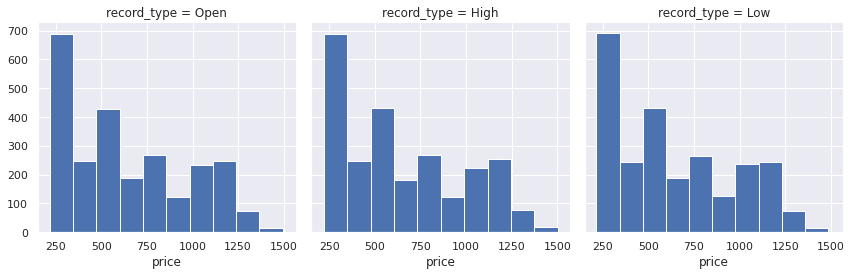

In [48]:
# Histogram of price distributions
g = sns.FacetGrid(tidy, col="record_type", height=4, aspect=1)
g.map(plt.hist, "price")

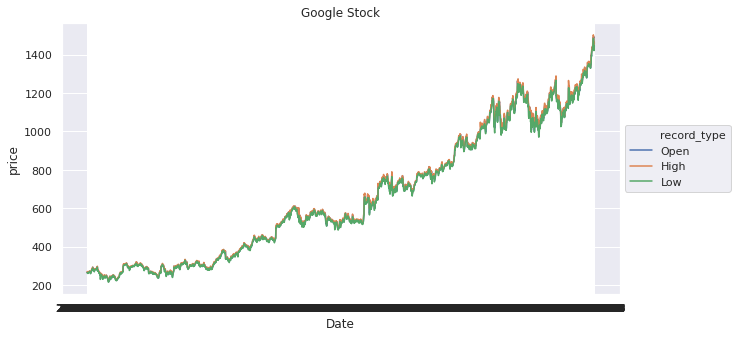

In [46]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.lineplot(data=tidy.reset_index(), x='Date', y='price', hue='record_type', ci=None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Google Stock')
plt.show()

**Check missing of zero values**

In [0]:
series.apply(lambda x: sum(x.isnull()),axis=0) 

present    0
past       0
dtype: int64

Another way of checking for missing values would be this:

In [0]:
series.isnull().sum()

present    0
past       0
dtype: int64

You can also visualize missing values:

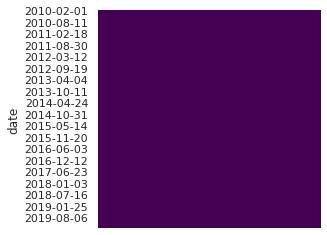

In [0]:
sns.set(rc={'figure.figsize':(4, 4)})
sns.heatmap(series.isnull(),xticklabels=False,cbar=False,cmap='viridis')

In [0]:
# Check for zeros
(series[series == 0]).count()

present    0
past       0
dtype: int64

**Distribution**

Before applying a causality test, we'll run a simple regression first. However, if the distribution of the time series is not normal, the application of robust regression is recommendable. So let's first run a goodness of fit test again normal distribution.

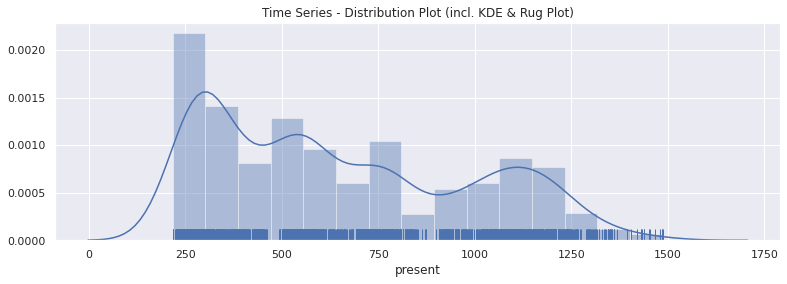

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series.present), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

Text(0.5, 1.0, 'Boxplot')

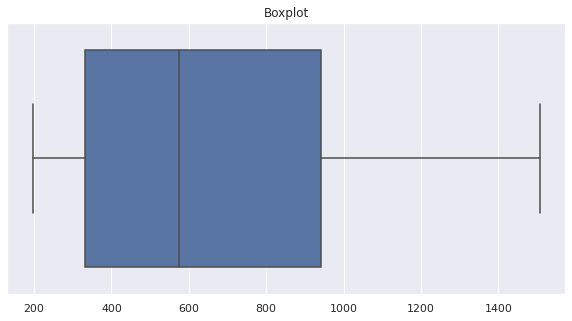

In [22]:
sns.boxplot(series).set_title('Boxplot')

In [0]:
# Normal Test. H0: sample comes from a normal distribution.
scipy.stats.normaltest(series)

NormaltestResult(statistic=array([741.93933605, 701.51553859]), pvalue=array([7.76104538e-162, 4.65410644e-153]))

Reject H0. Data are not drawn from a normal distribution.

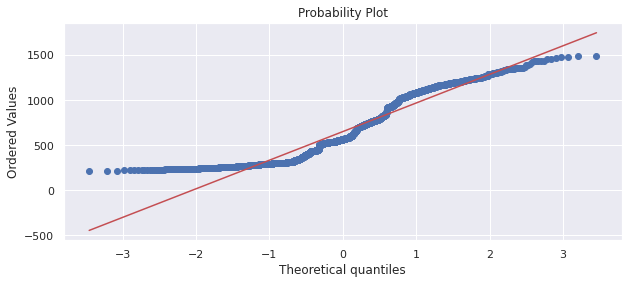

In [0]:
# QQ Plot against normal distribution
sns.set(rc={'figure.figsize':(10, 4)})
stats.probplot(series.present, dist="norm", plot=plt)
plt.show()

Visual confirmation that data is not normally distributed. 

**Autocorrelation**

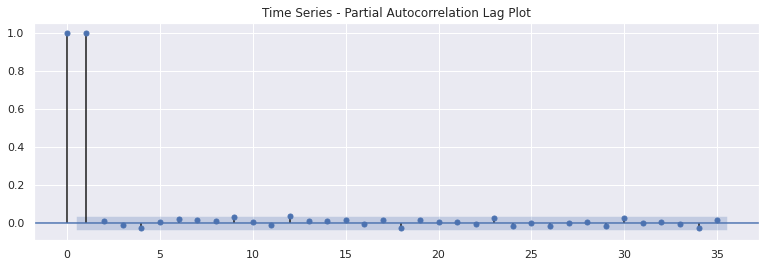

In [0]:
plot_pacf(series.present)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


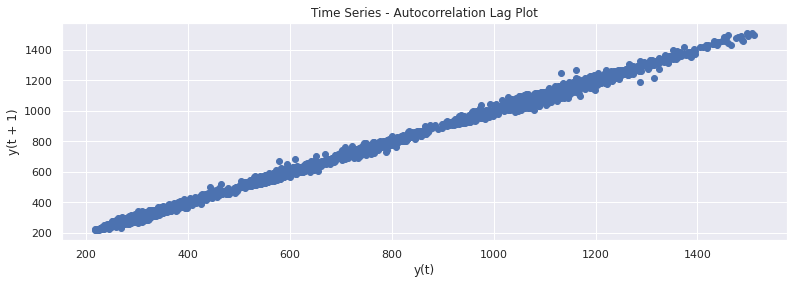

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

## **Stationarity Tests**

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary.

Most financial time series exhibit a unit root and need to be differenced once. Additionally they demonstrate a trend upward ('random walk with drift'). Also there might some seasonality.

**Stationarity Test (Past)**

In [0]:
# Augmented Dicker Fuller test. H0: There is a unit root for the series (non stationary)
statsmodels.tsa.stattools.adfuller(series.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.410023375528942,
 0.9973709746855136,
 3,
 2511,
 {'1%': -2.5666309774768794,
  '10%': -1.6167146542499096,
  '5%': -1.941107501055969},
 20515.119677609488)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-34.79359749571223,
 0.0,
 2,
 2511,
 {'1%': -2.5666309774768794,
  '10%': -1.6167146542499096,
  '5%': -1.941107501055969},
 20510.932357446254)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

**Stationarity Test (Present)**

In [0]:
statsmodels.tsa.stattools.adfuller(series.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9180072584443,
 0.9997040665808604,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.505835476455)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.300247000508126,
 1.7331869542573804e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18859.171083336038)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

## **Simple Regression**

Before conducting the Granger causality test, let's first simply regress one time series (past) on the other (present) to see if there is any relationship between them:

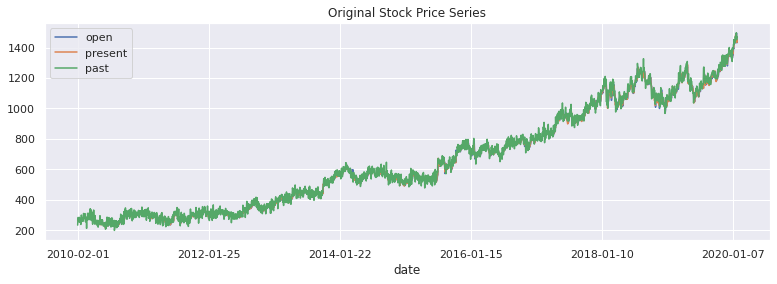

In [36]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='Original Stock Price Series')

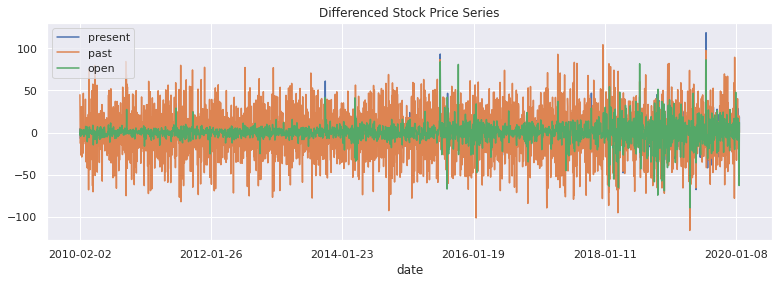

In [37]:
sns.set(rc={'figure.figsize':(13, 4)})
differenced.plot(linewidth=1.5,title='Differenced Stock Price Series')

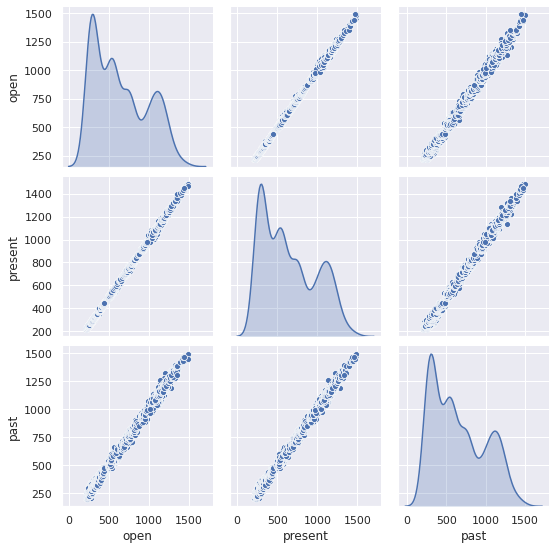

In [35]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

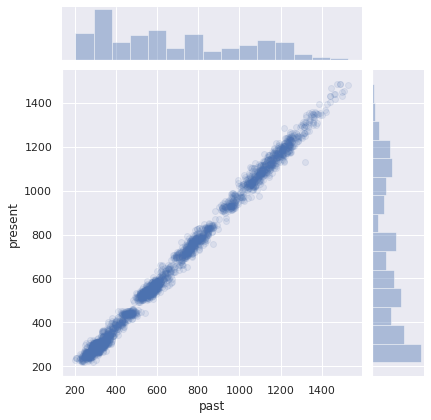

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

**Linear (Robust) Regression**

Visual confirmation that data is not normally distributed. Let's run another simple regression, but this time as **robust regression. This will de-weight outliers.** (Note that this is substantially more computationally intensive than standard linear regression, so you may wish to decrease the number of bootstrap resamples (n_boot) or set ci to None.)

Robust regression between (artificial) previous day close value and current day close value:

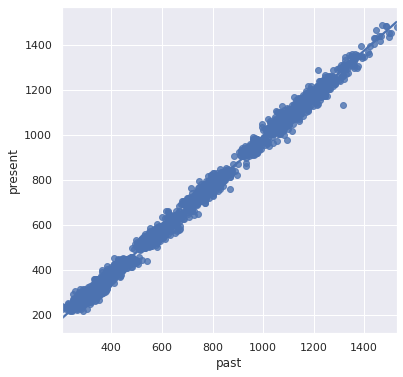

In [0]:
# Plot data and a robust regression model fit
sns.set(rc={'figure.figsize':(6, 6)})
sns.regplot(x="past", y="present", data=series, robust=True, ci=None)

Robus Regression Plot between current day open value and current day close value:

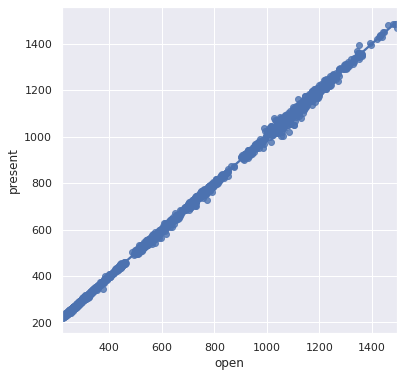

In [38]:
# Plot data and a robust regression model fit
sns.set(rc={'figure.figsize':(6, 6)})
sns.regplot(x="open", y="present", data=series, robust=True, ci=None)

Confirming strong correlation between both time series.

# **Causality Tests**

Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

## **Johansen Cointegration**

Let's first run a **cointegration test**. If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions. (However note that the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.)

**Cointegration between (artificial) previous day close value and current day close value?**

In [33]:
# Johansen Cointegration. H0: There is no cointegration.
statsmodels.tsa.stattools.coint(differenced.past, differenced.present, trend='ct', method='aeg', autolag='aic')

(-19.983698464078202,
 1.156287064087559e-36,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

**Cointegration between current day open value and current day close value?**

In [34]:
# Johansen Cointegration. H0: There is no cointegration.
statsmodels.tsa.stattools.coint(differenced.open, differenced.present, trend='ct', method='aeg', autolag='aic')

(-11.0906150539508,
 1.7320731441099052e-19,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Granger Causality Test**

Granger causality require stationary data and data in same scale (or normalized) (Granger causality (1969) requires both series to be stationary. Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data.)

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. **Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors**. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

However note that:
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships (when two factors cause each other). Please see CCM (Convergent Cross Mapping) as a more advanced approach for non-linear relationships.


**First hypothesis test**: Does the (artificial) previous day value cause the current day close value?

In [31]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
df = differenced[['present', 'past']]
statsmodels.tsa.stattools.grangercausalitytests(df, maxlag = 5, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=372.3011, p=0.0000  , df_denom=2510, df_num=1
ssr based chi2 test:   chi2=372.7461, p=0.0000  , df=1
likelihood ratio test: chi2=347.5635, p=0.0000  , df=1
parameter F test:         F=372.3011, p=0.0000  , df_denom=2510, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=234.7695, p=0.0000  , df_denom=2507, df_num=2
ssr based chi2 test:   chi2=470.4755, p=0.0000  , df=2
likelihood ratio test: chi2=431.2461, p=0.0000  , df=2
parameter F test:         F=234.7695, p=0.0000  , df_denom=2507, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=169.4346, p=0.0000  , df_denom=2504, df_num=3
ssr based chi2 test:   chi2=509.7249, p=0.0000  , df=3
likelihood ratio test: chi2=464.0724, p=0.0000  , df=3
parameter F test:         F=169.4346, p=0.0000  , df_denom=2504, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=138.1565, p=0.

{1: ({'lrtest': (347.5635370714517, 1.4378684349673773e-77, 1),
   'params_ftest': (372.301121435791, 1.8321451929983598e-77, 2510.0, 1.0),
   'ssr_chi2test': (372.74610285583367, 4.7237650284906595e-83, 1),
   'ssr_ftest': (372.3011214357909, 1.83214519299862e-77, 2510.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (431.24613808506547, 2.2703402245239782e-94, 2),
   'params_ftest': (234.7695313144661, 3.487257964834963e-94, 2507.0, 2.0),
   'ssr_chi2test': (470.4755186772556, 6.879219768402622e-103, 2),
   'ssr_ftest': (234.76953131446655, 3.487257964833278e-94, 2507.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (464.0723504768721, 2.9116235792390794e-100, 3),
   'params_ftest': (169.43463620748244, 5.305739479527614e-100, 2504.0, 3.0),
   'ssr_chi2test': (509.7248860027827, 3.724816346221538e-110, 3),
   'ssr_ftest': (169.43463620748275, 5.305739479525804e-100, 2504.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0

Excellent result: p-value is zero. Reject H0. It can be rejected that x2 (past values) does not Granger cause x1 (present values of same time series). Or in layman's terms: there is a strong indication that past price value cause the present price values.

**Second Hypothesis**: Does the current day open value cause the current day close value?

In [32]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
df = differenced[['present', 'open']]
statsmodels.tsa.stattools.grangercausalitytests(df, maxlag = 5, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2601  , p=0.2617  , df_denom=2510, df_num=1
ssr based chi2 test:   chi2=1.2616  , p=0.2613  , df=1
likelihood ratio test: chi2=1.2613  , p=0.2614  , df=1
parameter F test:         F=1.2601  , p=0.2617  , df_denom=2510, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3298  , p=0.0018  , df_denom=2507, df_num=2
ssr based chi2 test:   chi2=12.6849 , p=0.0018  , df=2
likelihood ratio test: chi2=12.6529 , p=0.0018  , df=2
parameter F test:         F=6.3298  , p=0.0018  , df_denom=2507, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2631  , p=0.0001  , df_denom=2504, df_num=3
ssr based chi2 test:   chi2=21.8503 , p=0.0001  , df=3
likelihood ratio test: chi2=21.7558 , p=0.0001  , df=3
parameter F test:         F=7.2631  , p=0.0001  , df_denom=2504, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.6303  , p=0.

{1: ({'lrtest': (1.2612874749247567, 0.26140752979267096, 1),
   'params_ftest': (1.260097958009845, 0.26173991435492183, 2510.0, 1.0),
   'ssr_chi2test': (1.261604051186968, 0.26134768385764895, 1),
   'ssr_ftest': (1.2600979580100633, 0.2617399143547778, 2510.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (12.65293288630346, 0.001788341825103848, 2),
   'params_ftest': (6.329802164010574, 0.0018110038861718172, 2507.0, 2.0),
   'ssr_chi2test': (12.684852840841538, 0.0017600264873392111, 2),
   'ssr_ftest': (6.329802164010696, 0.0018110038861716064, 2507.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (21.75575618196308, 7.332692611826738e-05, 3),
   'params_ftest': (7.263121367248413, 7.533145330835946e-05, 2504.0, 3.0),
   'ssr_chi2test': (21.850276860816823, 7.008153583222651e-05, 3),
   'ssr_ftest': (7.263121367248814, 7.533145330833096e-05, 2504.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],